# Zonas Inundables

Vamos a descargar un DTM de Argentina
https://www.ign.gob.ar/NuestrasActividades/Geodesia/ModeloDigitalElevaciones/Busqueda

## ¿Qué es un DTM?

Un **DTM** (Digital Terrain Model, o Modelo Digital del Terreno) es una representación digital de la superficie terrestre, generalmente obtenida a partir de mediciones topográficas, LiDAR, imágenes satelitales o drones. Este modelo refleja la **elevación natural del terreno**, excluyendo elementos artificiales como edificios o vegetación.  

Los DTMs son ampliamente utilizados en ingeniería civil, planificación urbana, gestión de recursos hídricos y estudios ambientales.

---

## Diferencia entre MDE y MDT

Aunque a veces se usan como sinónimos, hay una distinción técnica importante:

| Sigla | Nombre completo | Qué representa |
|-------|----------------|----------------|
| **MDE** | Modelo Digital de Elevaciones | Representa **todas las elevaciones** de la superficie terrestre, incluyendo terreno, vegetación, edificios y otras estructuras. |
| **MDT** | Modelo Digital del Terreno | Representa únicamente la **superficie desnuda del terreno**, es decir, excluye elementos artificiales o naturales que no sean parte del terreno. |

En resumen:  
- **MDE** = Todo lo que se puede medir en altura sobre el suelo.  
- **MDT / DTM** = Solo el terreno “limpio”, sin obstáculos.


In [6]:
# Matemática y arrays
import numpy as np

# Visualización
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Procesamiento raster
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.features import rasterize

# Procesamiento vectorial / geoespacial
import geopandas as gpd
from shapely.geometry import box

# Procesamiento de máscaras
from scipy.ndimage import binary_dilation

# OSM / datos abiertos
import osmnx as ox



ruta_dtm = "3957-2.img"

## Librerías para trabajar con rásteres

| Librería / Método | Nivel de dificultad | Tipos de ficheros | Tipo de análisis | Comentarios |
|------------------|------------------|-----------------|----------------|------------|
| **Rasterio** 🟢 | Fácil | GeoTIFF, IMG, JPEG2000, GRID, HFA | General / lectura y escritura | Moderna, estable, sintaxis clara. Ideal para la mayoría de proyectos Python. |
| **GDAL (osgeo.gdal)** 🔴 | Difícil | GeoTIFF, IMG, NetCDF, HDF, JP2, ASCII Grid y más | Avanzado / reproyecciones / conversiones | Control total, gran variedad de formatos, sintaxis más compleja. Útil para procesos precisos o conversiones masivas. |
| **rioxarray (xarray + rasterio)** 🟡 | Media | GeoTIFF, IMG, NetCDF, HDF, otros soportados por Rasterio | Series temporales / análisis espacial de múltiples rásteres | Alto nivel, integración con `xarray`, facilita trabajar con datasets multidimensionales. |
| **ArcPy / ArcGIS API** 🔵 | Media | GeoTIFF, IMG, GRID, ASCII Grid, muchos formatos propietarios de ESRI | GIS dentro de ArcGIS | Solo para entornos ArcGIS, permite automatizar procesos dentro del ecosistema ESRI. |

### Leyenda
- 🟢 Fácil: sintaxis clara, curva de aprendizaje baja  
- 🟡 Media: requiere experiencia con Python y manejo de rásteres  
- 🔴 Difícil: curva de aprendizaje pronunciada, uso avanzado  
- 🔵 Específico: depende de software propietario, no open source



In [2]:
with rasterio.open(ruta_dtm) as src: #esto es un rasterio DatasetReader
    dtm = src.read(1) #esto es un ndarray
    transform = src.transform #esto es un affine.Affine
    nodata = src.nodata #esto es un float
    crs = src.crs
    bounds = src.bounds

## ¿Por qué mi ráster usa `-999999` en vez de `NaN`?

Muchos formatos ráster tradicionales (como **IMG**, **GeoTIFF antiguos**, **ESRI GRID**, etc.) no almacenan valores *NaN* de forma nativa.  
En su lugar, utilizan un **valor especial** llamado *NoData value*, por ejemplo `-9999`, `-32768` o `-999999`, para indicar que un píxel **no contiene un valor válido**.

### ¿Por qué usar un valor NoData en vez de `NaN`?

- **Compatibilidad**: algunos programas SIG clásicos no soportan NaN, pero sí un valor numérico designado como NoData.  
- **Eficiencia interna**: ciertos formatos están pensados para enteros o para tamaños de celda fijos, donde introducir NaN rompería la estructura del archivo.  
- **Portabilidad**: usar un valor NoData asegura que cualquier software GIS pueda interpretar correctamente las celdas vacías o sin información.  
- **Control explícito**: permite definir exactamente qué valor se considera “inválido” o “fuera de rango”.

En Python, muchas librerías (incluyendo **Rasterio**, **GDAL** y **rioxarray**) detectan automáticamente este valor NoData si el archivo lo tiene definido en su metadata. Sin embargo, a veces no está definido y aparece simplemente como un número en el array.

In [8]:
## Sustituir el valor NoData por `NaN` en Python
# Cuando cargues el ráster, puedes reemplazar el valor NoData por `NaN` para trabajar más cómodamente con NumPy o xarray:
dtm[dtm == nodata] = np.nan

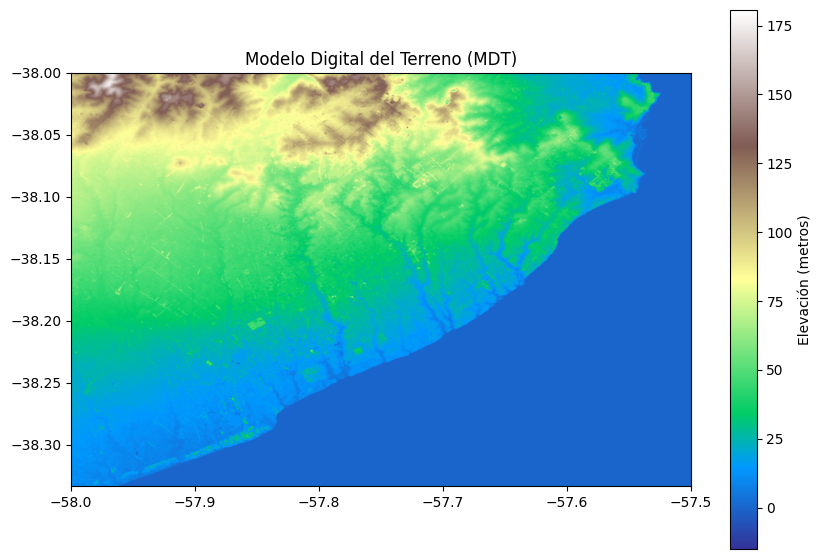

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

show(
    dtm,
    transform=transform,
    ax=ax,
    cmap='terrain'
)

ax.set_title("Modelo Digital del Terreno (MDT)")

# Barra de color
cbar = plt.colorbar(ax.images[0], ax=ax, shrink=0.7)
cbar.set_label("Elevación (metros)")

plt.show()

### Recortar el dtm

In [10]:
lon_min, lon_max = -57.540, -57.490
lat_min, lat_max = -38.030, -38.010

recorte = box(lon_min, lat_min, lon_max, lat_max)

with rasterio.open(ruta_dtm) as src:
    # Recorta directamente usando el bbox
    out_img, out_transform = mask(src, [recorte], crop=True)
    dtm_crop = out_img[0].astype(float)

# Convertir NoData a NaN
dtm_crop[dtm_crop == nodata] = np.nan

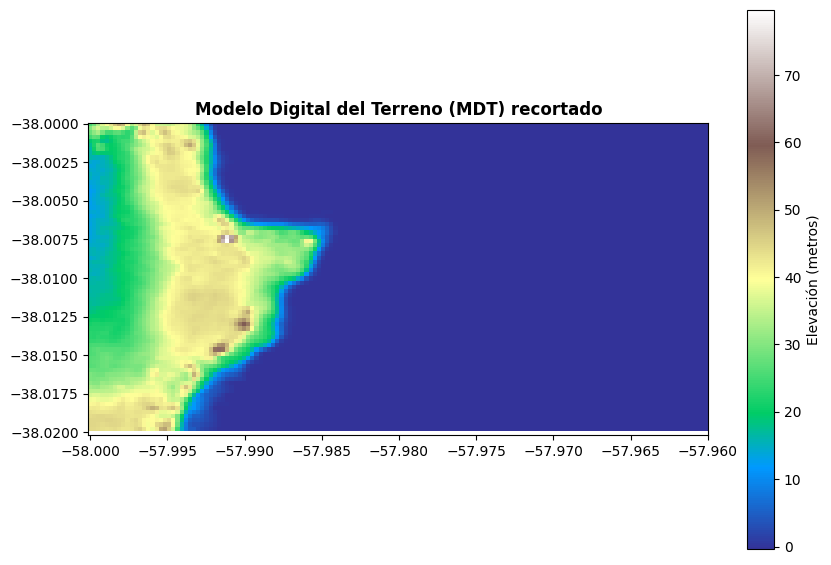

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
show(dtm_crop, 
     transform=transform, 
     ax=ax, 
     cmap='terrain', 
     title='Modelo Digital del Terreno (MDT) recortado')

cbar = plt.colorbar(ax.images[0], ax=ax, shrink=0.7)
cbar.set_label('Elevación (metros)')
plt.show()

**OpenStreetMap (OSM)** es un proyecto colaborativo y abierto que crea y mantiene un mapa mundial editable por cualquier persona, similar a una “Wikipedia del mapa”. Sus datos incluyen carreteras, edificios, puntos de interés, usos del suelo, servicios y miles de tipos de *features* descritas de forma comunitaria. Es gratuito, libre y utilizado ampliamente en SIG, aplicaciones móviles, investigación y desarrollo web.

- 🌍 **Web oficial:** https://www.openstreetmap.org  
- 📚 **Documentación (OSM Wiki):** https://wiki.openstreetmap.org/wiki/  
- 🏷️ **Página de etiquetado (todas las *features*, tags y convenciones):** https://wiki.openstreetmap.org/wiki/Map_features  


### Descargar la linea de costa desde OSM

In [13]:

extent_bbox = [lon_min,  lat_min,lon_max, lat_max]
gdf_costa = ox.features_from_bbox(extent_bbox, tags={"natural": "coastline"}) # ¡Puede tardar varios minutos!

# Proyectar al CRS del raster
costa = gdf_costa.to_crs(crs)

# Recortar la línea de costa al área del DTM
costa_rec = costa.clip(recorte)


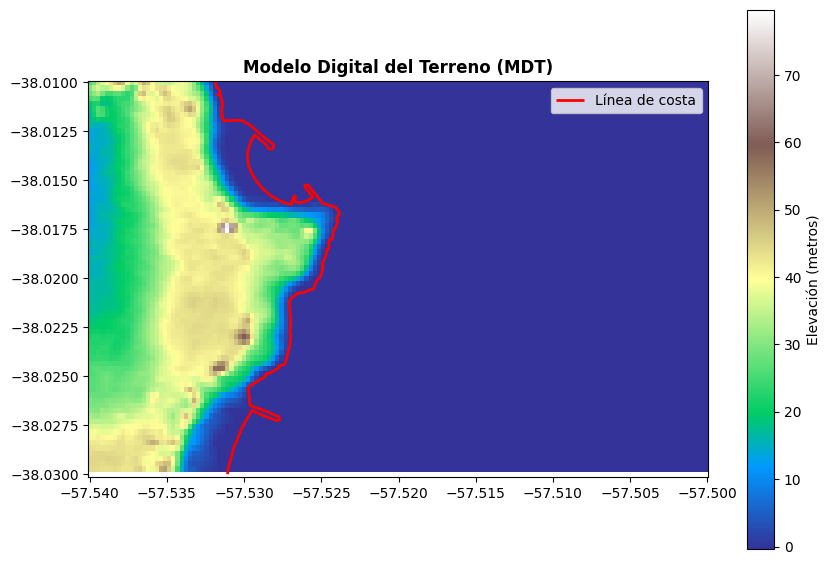

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
# Mostrar el DTM
show(dtm_crop, 
     transform=out_transform, 
     ax=ax, 
     cmap='terrain', 
     title='Modelo Digital del Terreno (MDT)')

costa_rec.plot(ax=ax, color='red', linewidth=2, label='Línea de costa')
cbar = plt.colorbar(ax.images[0], ax=ax, shrink=0.7)
cbar.set_label('Elevación (metros)')
ax.legend()
plt.show()

### Rasterizar la línea de costa

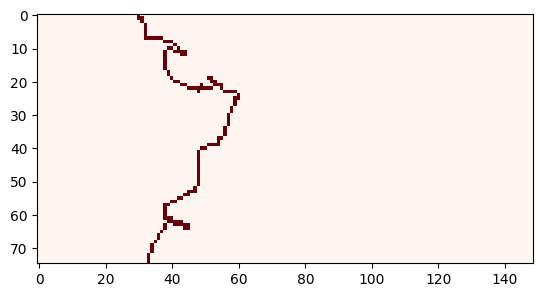

In [17]:
mask_costa = rasterize(
    [(geom, 1) for geom in costa_rec.geometry], # Geometrías a pintar, Le dice a rasterize: "dibuja esta geometría, y donde caiga, pon un 1" 
    out_shape=dtm_crop.shape, # Tamaño de la imagen (igual que tu raster), forma el array de destino
    transform=out_transform, # Donde está cada píxel (la georreferenciación). Le dice: "este píxel (fila, columna) está en tal lugar del mundo". Es como la “regla” para mapear coordenadas reales a píxeles.
    fill=0, # Qué valor poner donde NO hay línea
    dtype='uint8'  # Tipo de dato (número entero pequeño)
)

mask_bool = mask_costa.astype(bool) #Rasterio no admite valores booleanos porque los rasteres de almacenan en tipo numéricos

# Visualizacion rápida
plt.imshow(mask_bool, cmap='Reds')


### Crear máscara de inundación inicial

In [32]:
altura_ola = 20   # m

# Píxeles con altura menor al agua → inundables 
nivel_mar = dtm_crop < altura_ola

# Semilla de inundación: costa + baja altura
inundado = mask_bool & nivel_mar

### Propagación tipo bathub

In [33]:
#  Propagar la inundación iterativamente mientras haya más píxeles nuevos que podamos inundar
while True:
    inundado_nuevo = binary_dilation(inundado) & nivel_mar
    if np.array_equal(inundado, inundado_nuevo):
        break
    inundado = inundado_nuevo

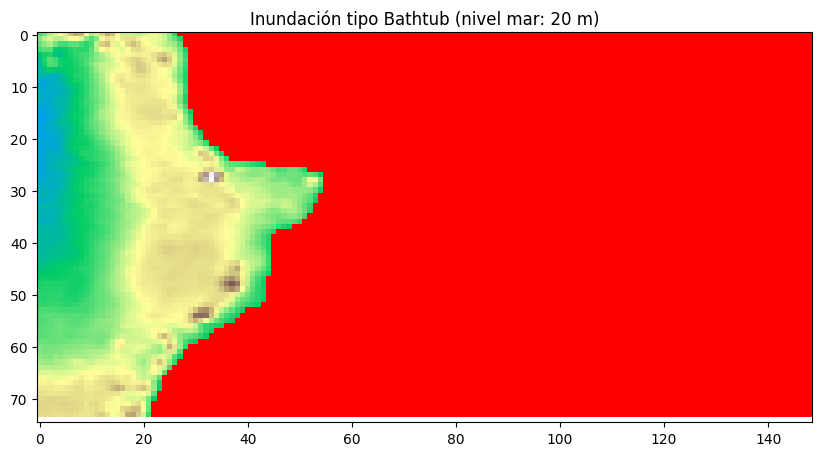

In [34]:
plt.figure(figsize=(10, 8))
plt.imshow(dtm_crop, cmap='terrain', alpha=1)
plt.imshow(np.ma.masked_where(~inundado, inundado), cmap=ListedColormap(['red']), alpha=1, vmin=0, vmax=altura_ola)
plt.title(f"Inundación tipo Bathtub (nivel mar: {altura_ola} m)")
plt.show()


### Descargar edificios de OSM y evaluar impactos

In [35]:
# Visualización de la zona en https://www.openstreetmap.org/query?lat=-38.028884&lon=-57.531742#map=16/-38.02881/-57.53205
tags = {"building": True, "man_made": True}
edificios = ox.features_from_bbox(extent_bbox, tags=tags)
edificios = edificios.to_crs(crs)

### Convertir píxeles inundados a polígonos para análisis espacial

In [36]:
rows, cols = np.where(inundado)

poligonos = []
for r, c in zip(rows, cols):
    x_min, y_max = rasterio.transform.xy(out_transform, r, c, offset='ul')
    x_max = x_min + out_transform.a
    y_min = y_max + out_transform.e
    poligonos.append(box(x_min, y_min, x_max, y_max))

gdf_inundados = gpd.GeoDataFrame(geometry=poligonos, crs=crs)

### Intersección edificio-inundación

In [37]:
impacto = gpd.sjoin(edificios, gdf_inundados, how="inner", predicate="intersects")
impacto = impacto.drop_duplicates()

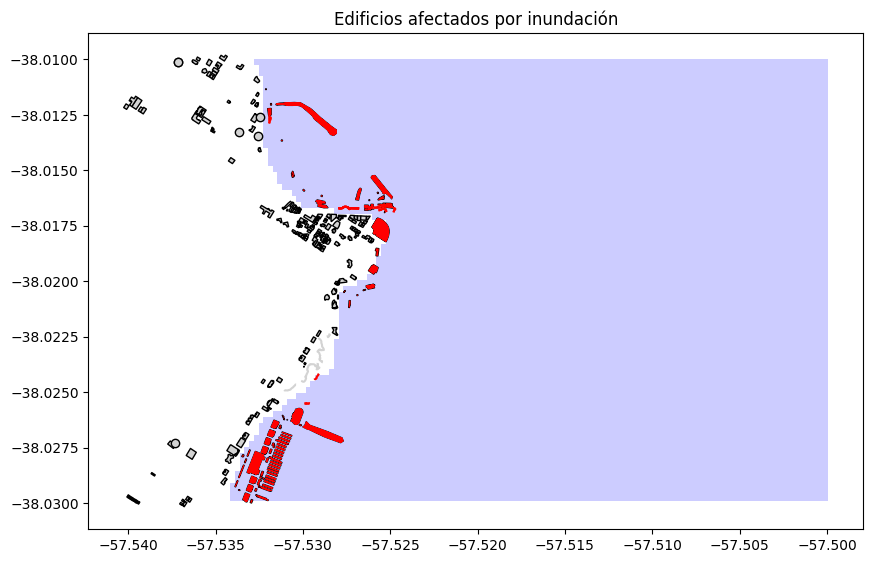

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_inundados.plot(ax=ax, color='blue', alpha=0.2)
edificios.plot(ax=ax, color='lightgrey', edgecolor='black')
impacto.plot(ax=ax, color='red')
plt.title("Edificios afectados por inundación")
plt.show()
